In [1]:
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH,MELD_DATA_PATH
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nb


Setting MELD_DATA_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data/output/preprocessed_surf_data
Setting EXPERIMENT_PATH to /rds/user/kw350/rds-kw350-meld/experiments/kw350/
Setting FS_SUBJECTS_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data/output/fs_outputs


In [2]:
def weighted_avg_and_std_ax(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights,axis=0)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights,axis=0)
    return (average, np.sqrt(variance))

In [3]:
#load cohort
site_codes=['H2', 'H3','H4','H5','H6','H7','H9','H10','H11','H12','H14','H15','H16','H17','H18','H19',
                  'H21','H23','H24','H26']
c= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5', dataset=None,
             data_dir=MELD_DATA_PATH)
listids_control = c.get_subject_ids(site_codes=site_codes, group='control', lesional_only=True)
demographics_file = '/rds/project/kw350/rds-kw350-meld/meld_data/Data/demographics_qc_allgroups.csv'


In [4]:
feature='.combat.on_lh.thickness.sm10.mgh'

In [5]:
#Load cortical thickness in controls
vals_subs=np.zeros((len(listids_control),2*len(c.cortex_mask)))
exclude_outliers_mask= np.ones(len(listids_control),dtype=bool)
for k,subject in enumerate(listids_control):
    subj = MeldSubject(subject, cohort=c)
    vals_hemi=[]
    try:
        for hemi in ['lh','rh']:
            vals = abs(subj.load_feature_values(feature, hemi=hemi))
            vals_hemi.extend(vals)
        vals_subs[k]=np.array(vals_hemi)
    except KeyError:
        print(subject)
        exclude_outliers_mask[k]=0
listids_control=np.array(listids_control)[exclude_outliers_mask]
vals_subs=vals_subs[exclude_outliers_mask]


In [6]:
## Load demographic data 
demographics = pd.read_csv(demographics_file,index_col=False)
variables_of_interest=['Age at preoperative', 'Sex']
dictionary_demo={}
for col in variables_of_interest:
    dictionary_demo[col]=[]
for sub in listids_control:
    for col in ['Age at preoperative', 'Sex']:
        dictionary_demo[col].append(demographics[col][demographics.ID==sub].values[0])
df = pd.DataFrame(dictionary_demo)

In [7]:
# Remove missing data
np.isnan(df).any()
# Remove controls with missing demographic info
indices=[]
for k,subject in enumerate(listids_control):
    if np.isnan(df['Age at preoperative'][k]) == True:
        print(subject)
        indices.append(k)
    elif np.isnan(df['Sex'][k]) == True:
        print(subject)
        indices.append(k)
    else:
        pass
vals_subs2 = np.delete(vals_subs, obj=indices, axis=0)
df2 = df.drop(indices)


MELD_H3_3T_C_0036


In [8]:
subj.get_demographic_features('Age at preoperative')

24.0

In [9]:
listids = c.get_subject_ids(site_codes=site_codes, group='patient', lesional_only=True)

#Load cortical thickness in patients
vals_p = []
lesions = []
included_p = []

for k,subject in enumerate(listids):
    subj = MeldSubject(subject, cohort=c)
    s= MeldSubject(subject,c)
    hemi = subj.get_lesion_hemisphere()
    if hemi:
        included_p.append(subject)
vals_p=np.zeros((len(included_p),2*len(c.cortex_mask)))
lesions =np.zeros((len(included_p),2*len(c.cortex_mask)))    
exclude_outliers_mask= np.ones(len(included_p),dtype=bool)
for k,subject in enumerate(included_p):
    subj = MeldSubject(subject, cohort=c)
    vals_hemi=[]
    lesion_h=[]
    try:
        for hemi in ['lh','rh']:
            lesion = np.round(subj.load_feature_values(hemi=hemi, feature=".on_lh.lesion.mgh")[:])
            vals = abs(subj.load_feature_values(feature, hemi=hemi))
            lesion_h.extend(lesion)
            vals_hemi.extend(vals)

        vals_p[k]=np.array(vals_hemi)
        lesions[k]=np.array(lesion_h)
    except KeyError:
        print(subject)
        exclude_outliers_mask[k]=0
included_p=np.array(included_p)[exclude_outliers_mask]
vals_p=vals_p[exclude_outliers_mask]
lesions=lesions[exclude_outliers_mask]


MELD_H5_3T_FCD_0027
MELD_H16_3T_FCD_044
MELD_H17_3T_FCD_0110
MELD_H17_3T_FCD_0138
MELD_H19_3T_FCD_003
MELD_H19_3T_FCD_004


In [10]:
variables_of_interest=['Age at preoperative', 'Sex','Duration','Lobe']
dictionary_demo={}
for col in variables_of_interest:
    dictionary_demo[col]=[]
for sub in included_p:
    for col in ['Age at preoperative', 'Sex','Duration','Lobe']:
        dictionary_demo[col].append(demographics[col][demographics.ID==sub].values[0])
df_p = pd.DataFrame(dictionary_demo)

In [11]:
# Remove patients with missing demographic info
indices=[]
for k,subject in enumerate(included_p):
    if np.isnan(df_p['Age at preoperative'][k]) == True:
        print(subject)
        indices.append(k)
    elif df_p['Age at preoperative'][k] > 80:
        print(subject)
        indices.append(k)
    elif np.isnan(df_p['Sex'][k]) == True:
        print(subject)
        indices.append(k)
    else:
        pass
vals_p2 = np.delete(vals_p, obj=indices, axis=0)
lesions2 = np.delete(lesions, obj=indices, axis=0)
df_p2 = df_p.drop(indices)
included_p2 = np.delete(included_p, obj=indices, axis=0)

MELD_H2_15T_FCD_0021
MELD_H12_3T_FCD_0027
MELD_H12_3T_FCD_0029
MELD_H12_3T_FCD_0030
MELD_H21_15T_FCD_0052
MELD_H21_3T_FCD_0001


(533, 2)

In [13]:
patient_zscores=np.zeros(np.shape(vals_p2))
control_zscores=np.zeros(np.shape(vals_subs2))

In [11]:
cortical_vertices = np.concatenate([c.cortex_label, len(c.cortex_mask)+c.cortex_label])

In [14]:
import GPy


In [27]:
k1 = GPy.kern.RBF(2, active_dims=(0, 1), lengthscale=2)
k2 = GPy.kern.White(2, active_dims=(0, 1))
k3 = GPy.kern.Linear(2)
k_add = k1 + k2 + k3

In [21]:
age=np.array(df2)

age_mean=np.mean(age,axis=0)
age_std=np.std(age,axis=0)
age_demean=(age-age_mean)/age_std



In [164]:
import time
t1=time.time()
for vertex_index in np.arange(500):
    y=vals_subs2[:,vertex_index]
    m = GPy.models.SparseGPRegression(age_demean, y.reshape(-1,1), kernel=k_add)
    m.optimize('bfgs', max_iters=100)
    mu,std=m.predict(
        pred_age_demean)
t2=time.time()
print(t2-t1)

48.10252642631531


In [68]:
flat_mu = np.mean(y)
flat_std = np.std(y)


0.3063240106393503

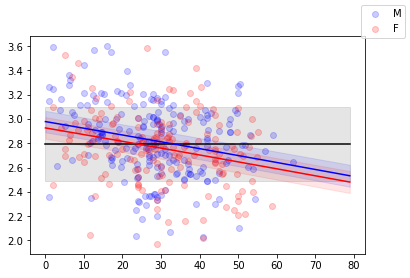

In [97]:


fig,ax = plt.subplots(1,1)
ax.plot(np.arange(80),np.tile(flat_mu,80),c='k')
ax.fill_between(np.arange(80), np.tile(flat_mu,80)+np.tile(flat_std,80),
                np.tile(flat_mu,80)-np.tile(flat_std,80),color='k' ,alpha=0.1)
pred_vals=np.hstack([np.vstack([np.arange(80),np.zeros(80)]),
                     np.vstack([np.arange(80),np.ones(80)])]).T

pred_age_demean=(pred_vals-age_mean)/age_std
mu,std=m.predict(
        pred_age_demean)
mu=mu.ravel()
std=std.ravel()
mu=mu.reshape((2,80)).T
std = std.reshape((2,80)).T
ax.plot(np.arange(80), mu[:,0],color='blue')
ax.fill_between(np.arange(80), mu[:,0]+std[:,0],mu[:,0]-std[:,0],color='blue' ,alpha=0.1)


ax.plot(np.arange(80), mu[:,1],color='red')
ax.fill_between(np.arange(80), mu[:,1]+std[:,1],mu[:,1]-std[:,1],color='red' ,alpha=0.1)

ax.scatter(X[:,0][X[:,1]==0], y[X[:,1]==0], c='blue', alpha=0.2,label='M')
ax.scatter(X[:,0][X[:,1]==1], y[X[:,1]==1], c='red', alpha=0.2,label='F')


fig.legend()

In [158]:
ages_p=np.round(np.array(df_p2[['Age at preoperative','Sex']])).astype(int)

y_p=vals_p2[:,vertex_index]
#pat demean = (ages_p-age_mean)/age_std
zs=[]
g_zs=[]
for sub,p_y in enumerate(y_p):
    m=mu[ages_p[sub,0]][ages_p[sub,1]]
    s=std[ages_p[sub,0]][ages_p[sub,1]]
    g_zs.append((p_y-m)/s)
    zs.append((p_y-flat_mu)/flat_std)

Text(0, 0.5, 'Orig z-score')

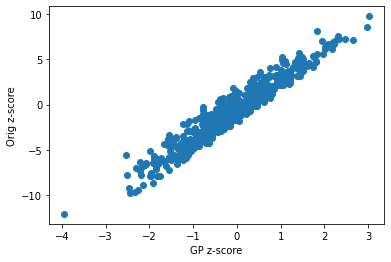

In [161]:
plt.scatter(zs,g_zs)
plt.xlabel('GP z-score')
plt.ylabel('Orig z-score')

In [12]:
from sklearn.linear_model import BayesianRidge

reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)

# reg.fit(X_train, y_train)
# ymean, ystd = reg.predict(X_test, return_std=True)

In [110]:
from pygam import LinearGAM, s, f
gam = LinearGAM(s(0) + s(1),lam=gam.lam)

# gam = LinearGAM(s(0) + s(1),lam=gam.lam)

n_vert=len(cortical_vertices)
t_stat=np.zeros( n_vert)
p_val=np.zeros( n_vert)
X=np.array(df2)
X2=np.array(df_p2[['Age at preoperative','Sex']])

for vertex_index in cortical_vertices:
    if vertex_index %1000 ==0:
        print(f'{vertex_index/vals_subs2.shape[1]*100} % done')
    vertex_index=1000
    y=vals_subs2[:,vertex_index]
    #fit model
    gam.fit(X, y)
    break
    #included_patients =not_lesions[:,vertex_index]
    #X2_vert = X2[included_patients]
    
    #y2 = vals_p2[included_patients,vertex_index]
#     y2=vals_p2[:,vertex_index]
#     #patient_zscore= gam.deviance_residuals(X2_vert,y2)
#     patient_zscore = gam.deviance_residuals(X2,y2)
#     control_zscore = gam.deviance_residuals(X,y)
# #     t,p=stats.ttest_ind(patient_zscore,control_zscore)
# #     t_stat[vertex_index]=t
# #     p_val[vertex_index]=p
#     patient_zscores[:,vertex_index]=patient_zscore
#     control_zscores[:,vertex_index]=control_zscore
#     break

0.0 % done


In [111]:
#predictions=gam.sample(X,y)
#X=X[:,0]
gam.fit(X, y)
s=np.vstack([np.arange(60),np.zeros(60)])
predictions=gam.predict_mu(s.T)

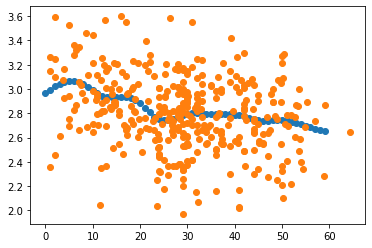

In [112]:
plt.scatter(np.arange(60),predictions)
plt.scatter(X[:,0],y)

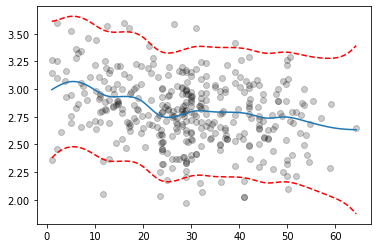

In [113]:

XX = gam.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam.predict( X=XX))
plt.plot(XX[:, 0], gam.prediction_intervals(XX, width=.95), c='r', ls='--')
plt.scatter(X[:,0], y, c='k', alpha=0.2)

In [161]:
import math
def weighted_avg_and_std_ax(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights,axis=0)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights,axis=0)
    return (average, np.sqrt(variance))

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [162]:
ages_x = X[:,0]


In [206]:
ages = np.arange(65)
mu=np.zeros((65,2*len(c.cortex_mask)))
std = np.zeros((65,2*len(c.cortex_mask)))
mu_ = np.zeros(65)
std_ = np.zeros(65)
weight_factor = 10
for age in ages:
    weights_diff = np.exp(-np.abs(ages_x-age) / weight_factor)
    #mu[age],std[age] = weighted_avg_and_std_ax(vals_subs2,weights_diff)
    mu_[age],std_[age] = weighted_avg_and_std(vals_subs2[:,1000],weights_diff)

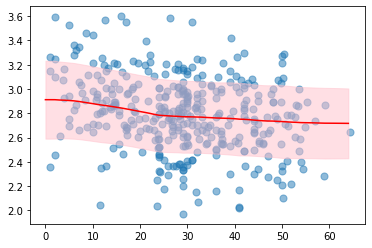

In [207]:
# mu_=mu[:,1000]
# std_=std[:,1000]
y=vals_subs2[:,1000]
fig,ax = plt.subplots(1,1)
ax.scatter(ages_x, y, s=50, alpha=0.5, label="observation")
ax.plot(ages, mu_, color="red", label="predict mean")
ax.fill_between(
    ages, mu_ - std_, mu_ + std_, color="pink", alpha=0.5, label="predict std"
)



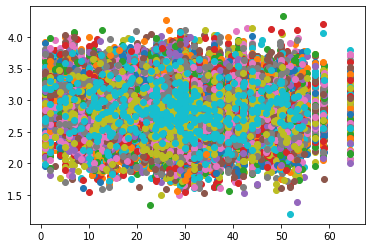

In [84]:
for x in predictions:
    plt.scatter(X[:,0],x)

In [63]:
n_order = 2

X_train = np.vander(X, n_order + 1, increasing=True)


In [59]:
reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)


In [60]:
#y=y+10*np.sin(X/10)
#X=X[:,0]

In [61]:
init = [2.0, 1]
reg.set_params(alpha_init=init[0], lambda_init=init[1])
reg.fit(X_train, y)


BayesianRidge(alpha_init=2.0, compute_score=True, fit_intercept=False,
              lambda_init=1, tol=1e-06)

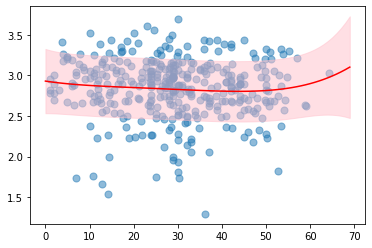

In [62]:
xx = np.arange(70)
xx_train = np.vander(xx, n_order + 1, increasing=True)

y_mean,y_std=reg.predict(xx_train, return_std=True)

fig,ax = plt.subplots(1,1)
ax.scatter(X, y, s=50, alpha=0.5, label="observation")
ax.plot(xx, y_mean, color="red", label="predict mean")
ax.fill_between(
    xx, y_mean - y_std, y_mean + y_std, color="pink", alpha=0.5, label="predict std"
)




In [85]:
import seaborn as sns
sns.kdeplot(control_zscore)
sns.kdeplot(patient_zscore)

NameError: name 'control_zscore' is not defined

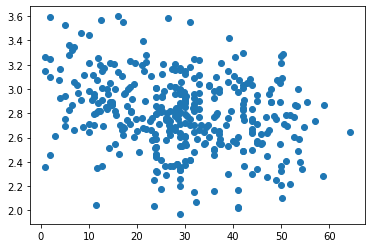

In [26]:
y=vals_subs2[:,1000]

plt.scatter(X[:,0],y)

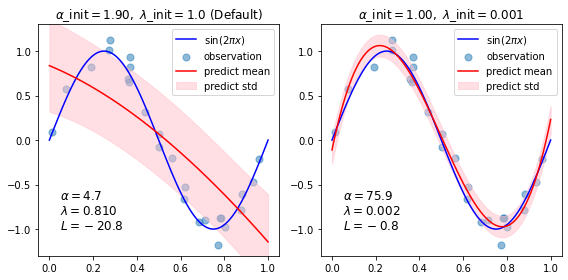

In [96]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import BayesianRidge


def func(x):
    return np.sin(2 * np.pi * x)


# #############################################################################
# Generate sinusoidal data with noise
size = 25
rng = np.random.RandomState(1234)
x_train = rng.uniform(0.0, 1.0, size)
y_train = func(x_train) + rng.normal(scale=0.1, size=size)
x_test = np.linspace(0.0, 1.0, 100)


# #############################################################################
# Fit by cubic polynomial
n_order = 3
X_train = np.vander(x_train, n_order + 1, increasing=True)
X_test = np.vander(x_test, n_order + 1, increasing=True)

# #############################################################################
# Plot the true and predicted curves with log marginal likelihood (L)
reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, ax in enumerate(axes):
    # Bayesian ridge regression with different initial value pairs
    if i == 0:
        init = [1 / np.var(y_train), 1.0]  # Default values
    elif i == 1:
        init = [1.0, 1e-3]
        reg.set_params(alpha_init=init[0], lambda_init=init[1])
    reg.fit(X_train, y_train)
    ymean, ystd = reg.predict(X_test, return_std=True)

    ax.plot(x_test, func(x_test), color="blue", label="sin($2\\pi x$)")
    ax.scatter(x_train, y_train, s=50, alpha=0.5, label="observation")
    ax.plot(x_test, ymean, color="red", label="predict mean")
    ax.fill_between(
        x_test, ymean - ystd, ymean + ystd, color="pink", alpha=0.5, label="predict std"
    )
    ax.set_ylim(-1.3, 1.3)
    ax.legend()
    title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(init[0], init[1])
    if i == 0:
        title += " (Default)"
    ax.set_title(title, fontsize=12)
    text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
        reg.alpha_, reg.lambda_, reg.scores_[-1]
    )
    ax.text(0.05, -1.0, text, fontsize=12)

plt.tight_layout()
plt.show()